In [ ]:
# code taken from source https://www.kaggle.com/code/derinrobert/newsclassification-using-lstm-val-acc-72

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-956378644f90>:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_json('drive/MyDrive/input/News_Category_Dataset_v3.json',lines=True)
beforeMay2018 = df[pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')<="2019-01-31"]

required_columns = ["BLACK VOICES",
                    "COMEDY",
                    "CRIME",
                    "DIVORCE",
                    "GREEN",
                    "HOME & LIVING",
                    "IMPACT",
                    "MEDIA",
                    "PARENTS",
                    "RELIGION",
                    "SPORTS",
                    "STYLE",
                    "THE WORLDPOST",
                    "WEDDINGS",
                    "WEIRD NEWS",
                    "WOMEN",
                    "WORLD NEWS",
                    "WORLDPOST"]
df = df[df["date"] < "2018-05-26"]
df = df[df["category"].isin(required_columns)]

df.drop(['authors', 'link', 'date'], axis = 1, inplace = True)

df.head()

,headline,category,short_description
8697,North Korea Still Open To Talks After Trump Cancels Summit,WORLD NEWS,Trump’s announcement came after repeated threats by North Korea to pull out of the summit over what it saw as confrontational remarks by U.S. officials.
8698,"2 Men Detonate Bomb Inside Indian Restaurant Near Toronto, Authorities Say",WORLD NEWS,"Fifteen people were taken to the hospital, three of them with critical injuries."
8699,Thousands Travel Home To Ireland To Vote On Abortion Access,WORLD NEWS,Just try to read these #HomeToVote tweets without crying.
8700,"Irish Voters Set To Liberalize Abortion Laws In Landslide, Exit Poll Signals",WORLD NEWS,Vote counting will begin Saturday.
8701,Warriors Coach Steve Kerr Calls NFL Ban On Protests 'Fake Patriotism',BLACK VOICES,"Forbidding players to take a knee during the national anthem is “idiotic,” the coach said."


In [ ]:
categories = df['category'].value_counts().index

def groupper(grouplist,name):
    for ele in categories:
        if ele in grouplist:
            df.loc[df['category'] == ele, 'category'] = name

In [ ]:
groupper( grouplist= ['WELLNESS', 'HEALTHY LIVING','HOME & LIVING','STYLE & BEAUTY' ,'STYLE'] , name =  'LIFESTYLE AND WELLNESS')

groupper( grouplist= [ 'PARENTING', 'PARENTS' ,'EDUCATION' ,'COLLEGE'] , name =  'PARENTING AND EDUCATION')

groupper( grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS','ARTS'] , name =  'SPORTS AND ENTERTAINMENT')

groupper( grouplist= ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'] , name =  'TRAVEL-TOURISM & ART-CULTURE')

groupper( grouplist= ['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'EMPOWERED VOICES')

groupper( grouplist= ['BUSINESS' ,  'MONEY'] , name =  'BUSINESS-MONEY')

groupper( grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')

groupper( grouplist= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')

groupper( grouplist= ['TECH', 'SCIENCE'] , name =  'SCIENCE AND TECH')

groupper( grouplist= ['FIFTY' , 'IMPACT' ,'GOOD NEWS','CRIME'] , name =  'GENERAL')

groupper( grouplist= ['WEDDINGS', 'DIVORCE',  'RELIGION','MEDIA'] , name =  'MISC')

In [ ]:
print("We have a total of {} categories now".format(df['category'].nunique()))
df['category'].value_counts()

We have a total of 8 categories now


SPORTS AND ENTERTAINMENT    12727
MISC                        12448
WORLDNEWS                   8419 
EMPOWERED VOICES            8018 
GENERAL                     6862 
LIFESTYLE AND WELLNESS      6449 
PARENTING AND EDUCATION     3955 
ENVIRONMENT                 2622 
Name: category, dtype: int64

In [ ]:
#from https://www.kaggle.com/code/dima806/news-category-classification-distilbert

item0 = df.shape[0]  # Store the initial number of items in the DataFrame
df = df.drop_duplicates()  # Remove duplicate rows from the DataFrame
item1 = df.shape[0]  # Store the number of items in the DataFrame after removing duplicates
print(f"There are {item0-item1} duplicates found in the dataset")  # Print the number of duplicates removed

df = df.rename(columns={'category': 'label'})  # Rename the 'category' column to 'label'

df['title'] = df['headline'] + ' ' + df['short_description']  # Create a new 'title' column by combining 'headline' and 'short_description'

df = df[['label', 'title']]  # Select only the 'label' and 'title' columns
df = df[~df['title'].isnull()]  # Remove rows where 'title' is null
df = df[~df['label'].isnull()]  # Remove rows where 'label' is null

print(df.shape)  # Print the shape of the DataFrame after data preprocessing
df.sample(5).T  # Display a random sample of 5 rows from the DataFrame

There are 218 duplicates found in the dataset
(61282, 2)


,114604,50027,169278,26719,194669
label,GENERAL,LIFESTYLE AND WELLNESS,MISC,SPORTS AND ENTERTAINMENT,LIFESTYLE AND WELLNESS
title,9-Month Old Shot By Father Cleaning Illegal Gun,Wes Anderson Directed The Most Wes Anderson Video Ever For H&M Of course Adrien Brody is the star.,"A Single Mom’s Guide To Living With Your Parents | Parenting - Yahoo! Shine You're divorced, stressing over your young daughter's future, and in a job situation that is, at best, Read more on shine.yahoo.com",The Story Behind The Stock Photo That Launched A Thousand Jokes What do we meme? Read on.,"How To Remove Sunscreen Stains From Clothing With Baking Soda Applying sunscreen is essential to protect your skin from the strong summer sun. Unfortunately, the chemical Avobenzone found"


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import gensim
from gensim.models import Word2Vec

In [ ]:
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import neattext.functions as nfx
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
tknzr = nltk.tokenize

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tknzr.word_tokenize(text)]

corpus = df['title'].astype(str)
corpus = corpus.apply(nfx.remove_stopwords)
corpus = corpus.apply(nfx.remove_special_characters)
corpus = corpus.apply(nfx.remove_multiple_spaces)
corpus = corpus.str.lower()
corpus = corpus.apply(lemmatize_text)

df['title'] = corpus

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data Tidying

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

In [ ]:
df.head()

,label,title
0,WORLDNEWS,"[trump, say, negotiate, brexit, tougher, attitude, theresa, i, said, european, union, cracked, it, supposed, be, taken, tougher, stand, getting, out]"
1,MISC,"[grandma, react, latest, wedding, trend, video, new, york, bridal, week, fashion, week, introduced, slew, new, wedding, dress, trend, hit, store, coming, year, including]"
2,GENERAL,"[superfoods, great, earth, health, there, plenty, help]"
3,EMPOWERED VOICES,"[hot, rap, song, chart, 25th, anniversary, 100, song, honor, 25th, anniversary, billboard, hot, rap, song, chart, were, counting, tally, 100, track, ever, read]"
4,EMPOWERED VOICES,"[espns, jemele, hill, trump, white, supremacist, unfit, office, we, addressed, jemele, recognizes, action, inappropriate, espn, said, statement]"


# Tokenizing and Padding

In [ ]:
X,Y = df['title'],df['label']

#80% to train , 10% for validation , 10% for testing
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)
X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state=42, stratify = y_val)

In [ ]:
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

word_vectors = KeyedVectors.load_word2vec_format('drive/MyDrive/input/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:



tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 20000, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
num_tokens = len(tokenizer.word_index.items()) + 2
vocabulary_size = min(len(word_index)+1, num_tokens)


EMBEDDING_DIM = 300




X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_train = np.asarray(y_train)
y_train = pd.get_dummies(y_train)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_val = np.asarray(y_val)
y_val = pd.get_dummies(y_val)

train_set = np.array(X_train)
val_set = np.array(X_val)

train_label = np.array(y_train)
val_label = np.array(y_val)


y_test = pd.get_dummies(y_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test,axis=1)   #this would be our ground truth label while testing

print(train_set.shape)
print(train_label.shape)


print(val_set.shape)
print(val_label.shape)




(49025, 300)
(49025, 8)
(6128, 300)
(6128, 8)


In [ ]:


embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=num_tokens:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)


embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)

# Model Training

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

tf.keras.backend.clear_session()

embed_size = 300

model = keras.models.Sequential([

      embedding_layer,
        keras.layers.Bidirectional(keras.layers.LSTM(256, dropout = 0.5)), #we try 0.6 or 0.5
        keras.layers.Dense(8, activation="softmax")

        ])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         14251500  
                                                                 
 bidirectional (Bidirection  (None, 512)               1140736   
 al)                                                             
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
Total params: 15396340 (58.73 MB)
Trainable params: 1144840 (4.37 MB)
Non-trainable params: 14251500 (54.37 MB)
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(train_set,train_label,
                     batch_size = 32,
                     steps_per_epoch=len(X_train) // 32,
                     validation_data = (val_set , val_label),
                     validation_steps = len(val_set)//32, epochs=20,
                     callbacks= early_stop)

Epoch 1/20
1532/1532 [==============================] - 71s 42ms/step - loss: 1.1027 - accuracy: 0.6133 - val_loss: 0.8938 - val_accuracy: 0.6936
Epoch 2/20
1532/1532 [==============================] - 65s 42ms/step - loss: 0.8981 - accuracy: 0.6868 - val_loss: 0.8104 - val_accuracy: 0.7197
Epoch 3/20
1532/1532 [==============================] - 63s 41ms/step - loss: 0.8121 - accuracy: 0.7173 - val_loss: 0.7695 - val_accuracy: 0.7407
Epoch 4/20
1532/1532 [==============================] - 63s 41ms/step - loss: 0.7477 - accuracy: 0.7388 - val_loss: 0.7261 - val_accuracy: 0.7546
Epoch 5/20
1532/1532 [==============================] - 63s 41ms/step - loss: 0.6967 - accuracy: 0.7567 - val_loss: 0.7236 - val_accuracy: 0.7493
Epoch 6/20
1532/1532 [==============================] - 63s 41ms/step - loss: 0.6567 - accuracy: 0.7691 - val_loss: 0.7146 - val_accuracy: 0.7565
Epoch 7/20
1532/1532 [==============================] - 65s 42ms/step - loss: 0.6128 - accuracy: 0.7858 - val_loss: 0.7145 -

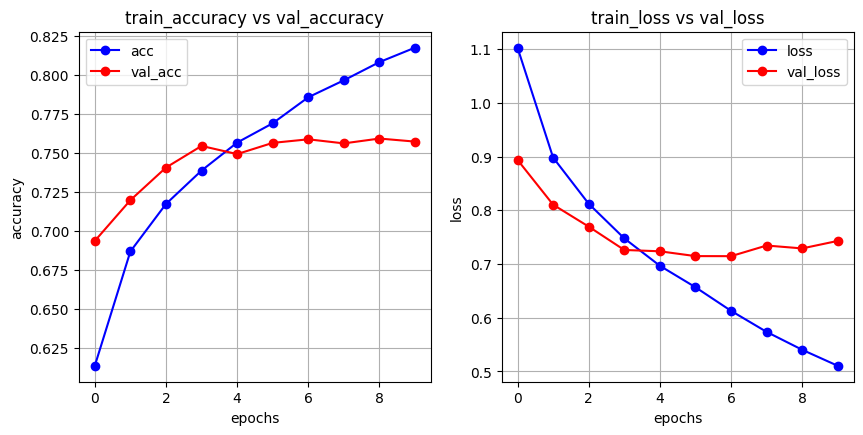

In [ ]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()


# Evaluating and Making Predictions

In [ ]:
classes = df['label'].value_counts().index

def prediction(inference_data):
    X = tokenizer.texts_to_sequences(inference_data)
    X = pad_sequences(X,maxlen= max_length,padding=padding_type, truncating=trunc_type)
    pred = model.predict(X)
    pred_value = tf.argmax(pred,axis =1).numpy()
    return pred_value

192/192 [==============================] - 4s 15ms/step
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       793
           1       0.70      0.64      0.67       261
           2       0.64      0.65      0.64       686
           3       0.87      0.80      0.83       641
           4       0.83      0.80      0.82      1244
           5       0.68      0.81      0.74       390
           6       0.70      0.83      0.76      1272
           7       0.83      0.79      0.81       842

    accuracy                           0.75      6129
   macro avg       0.75      0.74      0.74      6129
weighted avg       0.76      0.75      0.75      6129



Text(0.5, 1.0, 'Confusion matrix of model')

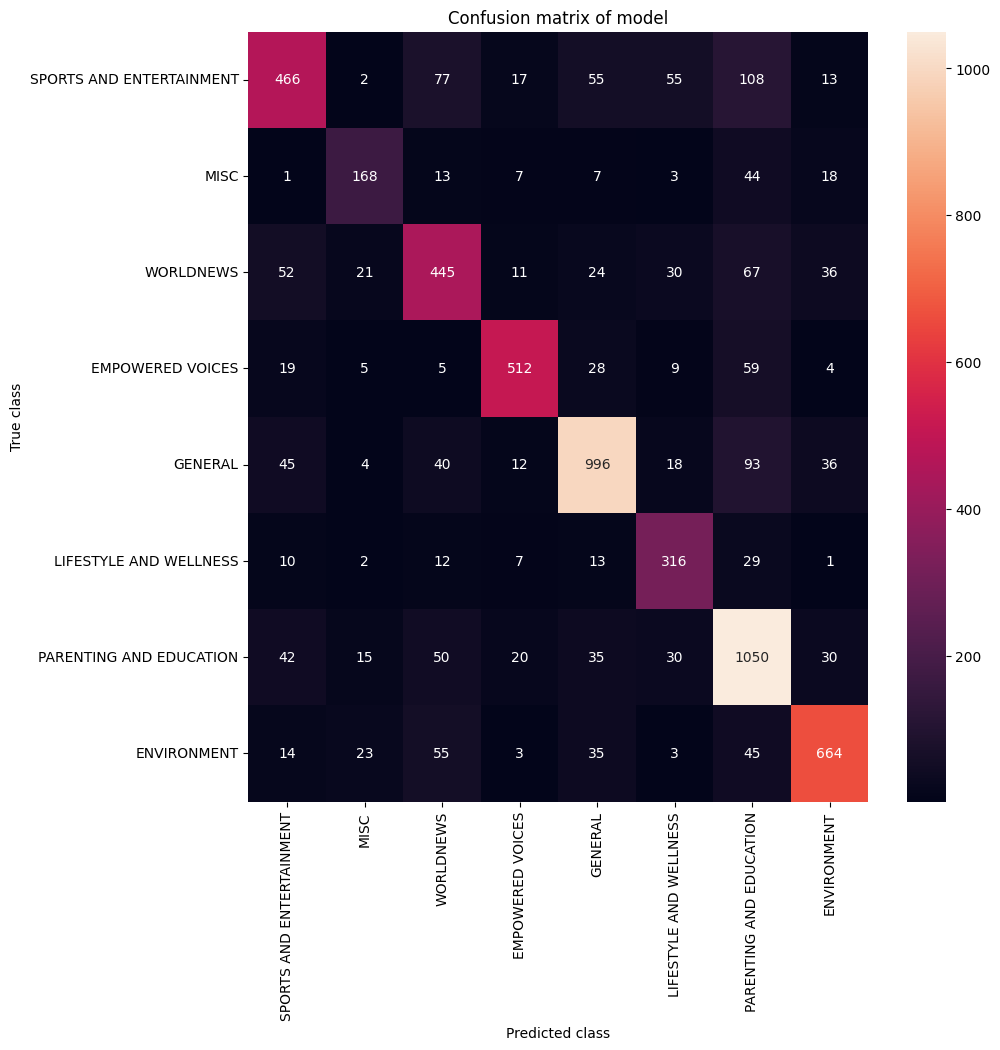

In [ ]:
y_pred = prediction(X_test)
print(classification_report(np.asarray(y_test),np.asarray( y_pred)))
cf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=classes,
                      yticklabels=classes,
                      annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')